In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')
sns.set_palette('Set1')
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
stock = ['AAPL']
indices = ['VTI', 'DBC', '^VIX', 'AGG']

In [3]:
start = '2022-01-01'
end = '2023-08-14'

prices = pd.read_csv('data/AAPL-VTI-DBC-VIX-AGG-prices-20220101-20230814.csv', index_col=0, parse_dates=True)
data = np.log(prices).diff()[1:]
data.head()

,AAPL,AGG,DBC,VTI,^VIX
Date,,,,,
2022-01-04,-0.012773,-0.000088,0.011913,-0.001895,0.018502
2022-01-05,-0.026960,-0.003094,-0.004273,-0.021928,0.154235
2022-01-06,-0.016834,-0.001063,0.008527,-0.000253,-0.006101
2022-01-07,0.000988,-0.002929,0.001885,-0.004564,-0.044313
2022-01-10,0.000116,-0.000889,-0.004246,-0.001738,0.033546


In [4]:
def replace_zeros_with_rolling_mean(series):
    non_zero_values = series.replace(0, np.nan)
    rolling_mean = non_zero_values.expanding().mean()
    for idx, value in series.items():
        if value == 0:
            series.at[idx] = rolling_mean.at[idx]

    return series

data = data.apply(replace_zeros_with_rolling_mean)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

X = data[indices]
y_linear = data[stock].squeeze()

X_train, X_test, y_train_linear, y_test_linear = train_test_split(X, y_linear, shuffle=False, test_size=.2, random_state=42)
y_train_logistic, y_test_logistic = np.sign(y_train_linear), np.sign(y_test_linear)

In [10]:
from sklearn.linear_model import LinearRegression, LogisticRegression

linear_regression = LinearRegression()
logistic_regression = LogisticRegression(random_state=42)

linear_regression.fit(X_train, y_train_linear)
logistic_regression.fit(X_train, y_train_logistic);

In [11]:
from sklearn.metrics import accuracy_score

y_pred_lin = np.sign(linear_regression.predict(X_test))
y_pred_log = logistic_regression.predict(X_test)

accuracy_lin = accuracy_score(np.sign(y_test_linear), y_pred_lin)
accuracy_log = accuracy_score(y_test_logistic, y_pred_log)

accuracies = {
    'Model': ['Linear Regression', 'Logistic Regression'],
    'Accuracy': [str(np.round(accuracy_lin * 100, 2)) +'%', str(np.round(accuracy_log * 100, 2)) +'%']
}

accuracy_df = pd.DataFrame(accuracies).set_index('Model')
accuracy_df

,Accuracy
Model,
Linear Regression,75.31%
Logistic Regression,61.73%


In [12]:
backtest_data = prices.filter(stock)[-len(y_pred_lin):]
backtest_data['lin_reg_signal'] = y_pred_lin
backtest_data['log_reg_signal'] = y_pred_log
backtest_data['lin_reg_signal'] = backtest_data['lin_reg_signal'].shift()
backtest_data['log_reg_signal'] = backtest_data['log_reg_signal'].shift()
models = ['lin_reg', 'log_reg']

transactions = {
    model: {
        'buys': [],
        'sells': [],
    } for model in models
}

def log_transactions(transactions, models, backtest_data):
    for model in models:
        in_position = False
        
        for _, row in backtest_data.iterrows():
            signal = row[f'{model}_signal']

            if signal == 1 and not in_position:
                in_position = True
                transactions[model]['buys'].append(row[stock].values[0])
            
            elif signal == -1 and in_position:
                in_position = False
                transactions[model]['sells'].append(row[stock].values[0])
            
        transactions[model]['profit'] = [(sell - buy) / buy for sell, buy in zip(transactions[model]['sells'], transactions[model]['buys'])]
        transactions[model]['profit'].insert(0, 0)
        transactions[model]['profit'] = (np.cumprod(1 + np.array(transactions[model]['profit'])) - 1)[-1]
    return transactions

transactions = log_transactions(transactions, models, backtest_data)

In [13]:
for model in models:
    print(f'{model}: \t {transactions[model]["profit"]*100:,.2f}%')

lin_reg: 	 2.27%
log_reg: 	 -0.97%


In [14]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Create a GridSearchCV object
log_reg_grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5)

# Fit to the data
log_reg_grid.fit(X_train, y_train_logistic)

# Get the best parameters and model
tuned_params = log_reg_grid.best_params_
log_reg_tuned = log_reg_grid.best_estimator_

# Predict on the test set
y_pred_log_tuned = log_reg_tuned.predict(X_test)

# Evaluate accuracy
accuracy_log_tuned = accuracy_score(y_test_logistic, y_pred_log_tuned)

print("Tuned Logistic Regression Accuracy:", accuracy_log_tuned)
print("Best Parameters:", tuned_params)

Tuned Logistic Regression Accuracy: 0.7283950617283951
Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [15]:
backtest_data['log_reg_tuned_signal'] = y_pred_log_tuned
backtest_data['log_reg_tuned_signal'] = backtest_data['log_reg_tuned_signal'].shift()

all_models = models + ['log_reg_tuned']

transactions2 = {
    model: {
        'buys': [],
        'sells': [],
    } for model in all_models
}

transactions2 = log_transactions(transactions2, all_models, backtest_data)

In [16]:
for model in all_models:
    print(f'{model}: \t {transactions2[model]["profit"]*100:,.2f}%')

lin_reg: 	 2.27%
log_reg: 	 -0.97%
log_reg_tuned: 	 1.39%


In [19]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test_logistic, y_pred_log_tuned)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[26 15]
 [ 7 33]]


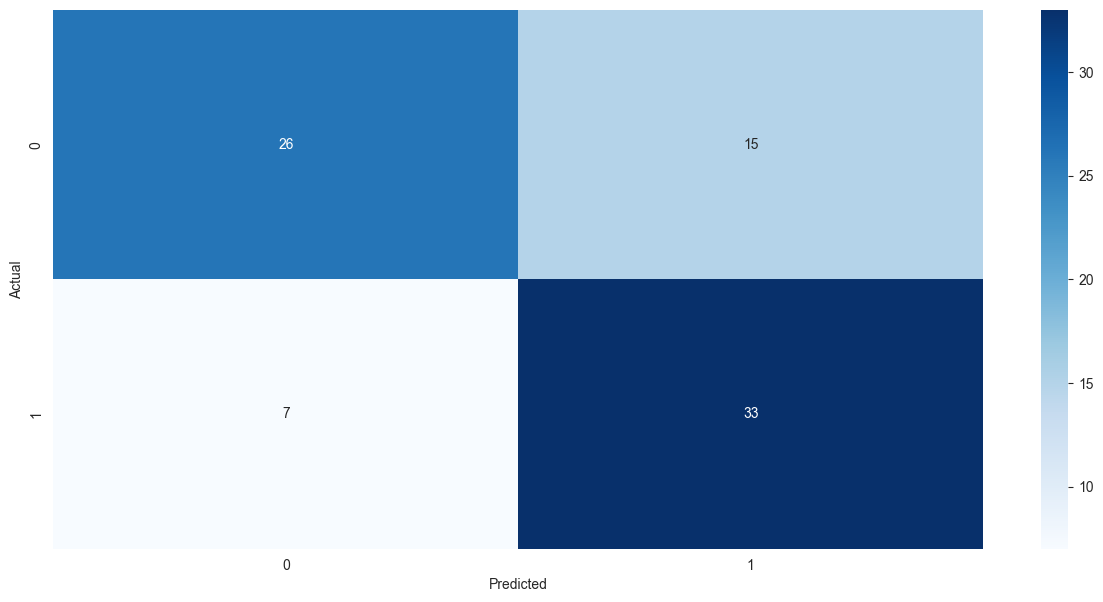

In [20]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()